In [15]:
#Linzy Programming Revision - Python
#import modules needed to execute functions
#standard modules
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import sys
import os
from pandas import DataFrame
from ranges import RangeDict, Range #pip python-ranges
#%matplotlib inline
plt.rcParams['figure.figsize']=(15,6)

#data preprocessing modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

#model modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

#metric modules
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

#get current working directory
os.getcwd()

'C:\\Users\\Kysha\\Documents\\flaskproject'

In [16]:
#import data from DAT650
def dataset(path_filename):
	#insert import error if file does not exist or type is not CSV
	try:
		data=pd.read_csv(path_filename, encoding='latin1')
		return data
	except IOError:
		print ('File does not exist or file type is not CSV.')
		sys.exit(1)

#list path and file name for data to import
original_data=dataset('Credit_Data.csv')
#original_data

#make copy of data
od=original_data

In [17]:
#make groups for continuous data (Amount, Duration, Age)
AMT_DICT=RangeDict({Range(0,1360):1,Range(1360,2300):2,
                    Range(2300,3900):3,Range(3900,max(od.AMOUNT)+1):4})
od['AMOUNT_GROUP']=[AMT_DICT[i] for i in od.AMOUNT]

DUR_DICT=RangeDict({Range(0,12):1,Range(12,18):2,Range(18,24):3,
                    Range(24,max(od.DURATION)+1):4})
od['DURATION_GROUP']=[DUR_DICT[i] for i in od.DURATION]

AGE_DICT=RangeDict({Range(0,27):1,Range(27,33):2,Range(33,42):3,
                    Range(42,max(od.AGE)+1):4})
od['AGE_GROUP']=[AGE_DICT[i] for i in od.AGE]


In [18]:
#create dummies for categorical columnns; including prefix to reference original feature
def dummies(feature):
	dummy_feature=pd.get_dummies(feature,
	prefix=feature.name, dtype=int)
	return dummy_feature

dummy_variables=pd.concat([dummies(od["SAV_ACCT"]),
	dummies(od["EMPLOYMENT"]),
	dummies(od["PRESENT_RESIDENT"]),
	dummies(od["JOB"]),
	dummies(od["HISTORY"]),
	dummies(od["AMOUNT_GROUP"]),
	dummies(od["DURATION_GROUP"]),
	dummies(od["AGE_GROUP"]),
	dummies(od["INSTALL_RATE"]),
	dummies(od["CHK_ACCT"]),
	dummies(od["NUM_CREDITS"]),
	dummies(od["NUM_DEPENDENTS"])], axis=1)


In [19]:
"""
concatenate dummy variables and variable for data without dropped columns to create new dataset
print columns names and inspect. Output will show a list of new columns with format
("Old_Column_1", "Old_Column_2"), etc...
"""
def new_dataset(original_dataset,dummies):
	new=pd.concat([original_dataset,dummies], axis=1)
	return new

new_data=new_dataset(od, dummy_variables)
#new_data.columns

In [20]:
"""
drop the columns for the original features transformed by dummy variables
and create a data variable for remaining columns
"""
data2=new_data.drop(["DURATION","NUM_DEPENDENTS", "NUM_CREDITS","INSTALL_RATE", "AMOUNT",'AGE','OBS#', "AMOUNT_GROUP", "AGE_GROUP", "DURATION_GROUP", "CHK_ACCT", "SAV_ACCT", "EMPLOYMENT", "PRESENT_RESIDENT", "JOB", "HISTORY"], axis=1)
#data2.columns
#data2.to_csv('credit_data_new2.csv')

In [21]:
#create data variables for independent features. Ouput variable count
def independent_variables(data, target_column):
	ind_var = (data.drop(target_column, axis=1))
	return ind_var

independent_variable=independent_variables(data2, "DEFAULT")
#len(independent_variable.columns)

#create a list of feature names for independent variables to be used for labeling later
ind_var_list=list(independent_variable.columns)


In [22]:
#create data variables for depentent features
def dependent_variables(target_column):
	dep_var = (target_column)
	return dep_var

dependent_variable=dependent_variables(data2[["DEFAULT"]])
#dependent_variable.columns

In [23]:
#split independent and depentent features into a training set(70%) and a testing set(30%)
train_features, test_features, train_labels, test_labels = train_test_split(independent_variable,
dependent_variable,test_size = 0.30,random_state = 42)

"""
print the shape of each of the 4 split data sets. Output is
("Training Features Shape: (700, 50), Training Labels Shape: (700, 1)"), etc...
"""
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (700, 67)
Training Labels Shape: (700, 1)
Testing Features Shape: (300, 67)
Testing Labels Shape: (300, 1)


In [24]:
def classifier_scoring (train_feature, test_feature, train_label, test_label):
	"""
	build a list of classifiers to be used in pipeline for multi model scoring that will be 	used
	to select top 3 models
	"""
	classifiers = [
	RandomForestClassifier(random_state=42),
	SVC(random_state=42),
	GradientBoostingClassifier(random_state=42),
	LogisticRegression(random_state=42)
	]
	"""
	build pipeline for the 4 classifiers and print cross validation scores
	output is a list of 4 scores in decimal form, "Scores 0.7165805316291562"
	"""
	scores=[]
	for i in classifiers:
		pipe = Pipeline(steps=[('classifier', i)])
		pi=pipe.fit(train_features, train_labels)
		scores.append(cross_val_score(pi, test_features, test_labels, cv=5,
		verbose=True).mean())
	return ["Random Forest Score {}".format(scores[0]), "SVC Score {}".format(scores[1]), "Gradient Boosting Score {}".format(scores[2]),
	"Logistic Regression Score {}".format(scores[3])]

In [25]:
#get top 3 classifiers by score results. Output list of top three classifers
#raise exception if number of classifiers do not match number of score results
try:
	score_results=classifier_scoring(train_features, test_features,
	train_labels, test_labels)
	print("Top 3 Classifiers: {}".format(sorted(score_results, reverse=False)[:3]))
except IndexError:
	print("No Results. Number of classifers need to match number of scores to return!")
else:
	pass


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Top 3 Classifiers: ['Gradient Boosting Score 0.7103000833564879', 'Logistic Regression Score 0.7469741594887468', 'Random Forest Score 0.7098592201537464']


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [26]:
"""
Each of the 3 top model were ran against 3 techniques which were:
1. run without optimization
2. run on cross validation and grid search with best parameter selection
3. run with feature reduction by importance
"""

def random_forest_cross_validation_gridsearch(train_feature, train_label):
	#random forest model. seed set at 42
	rf_exp = RandomForestClassifier(random_state=42)
	"""
	The best performing model for random forest was the cross validation
	and grid search with best parameter selection
	"""
	"""
	create selection pool for random forest randomized grid search parameters.
	Randomized search will try all parameter options
	"""
	#Number of trees in random forest
	n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 10)]
	#Number of features to consider at every split
	max_features = ['auto', 'sqrt', 'log2']
	#Maximum number of levels
	max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
	max_depth.append(None)
	#Minimum number of samples
	min_samples_split = [2, 5, 10]
	#Minimum number of samples required at each leaf node
	min_samples_leaf = [1, 2, 4]
	#Method of selecting samples for training each tree
	bootstrap = [True, False]
	#function to measure the quality of a split
	criterion = ['gini', 'entropy']
	"""
	minimum weighted fraction of the sum total
	of weights (of all the input samples) required to be at a leaf node
	"""
	class_weight = ['balanced', 'balanced_subsample']
	#provide error exception that specifically states the problem is "missing parameter
	try:
		#build parameter grid for the randomized grid search
		random_grid = {'n_estimators': n_estimators,
		'max_features': max_features,
		'max_depth': max_depth,
		'min_samples_split': min_samples_split,
		'min_samples_leaf': min_samples_leaf,
		'bootstrap': bootstrap,
		'criterion': criterion,
		'class_weight': class_weight}
	except NameError:
		print("Missing parameter from grid parameter definition!")
	else:
		pass
	"""
	create cross validation randomized grid search for random forest incorporating random forest model
	parameter grid, number of iteration set to 100, 5 folds. seed set at 42
	"""
	rf_exp_random = RandomizedSearchCV(estimator = rf_exp,
	param_distributions = random_grid,
	n_iter = 100, cv = 5, verbose=2,
	random_state=42, n_jobs = -1)
	#create and fit the cross validation model
	fit=rf_exp_random.fit(train_feature, train_label)
	return fit

In [27]:
rf_best_parameters=random_forest_cross_validation_gridsearch(train_features, train_labels)
rf_best_parameters

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [28]:
"""
capture best paramerter from the resulted randomized grid search model.
Output is a list of best parameters from the search
"""
best_parameters = rf_best_parameters.best_params_
print(best_parameters)

{'n_estimators': 460, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}


In [29]:
"""
update random forest with best parameters results and fit.
"""
#create parameter value list to be used in classifier
parameter_list=list(best_parameters.values())

#set classifier parameters to best_parameter.values to ensure they are updated to output
rf_exp_par = RandomForestClassifier(n_estimators= parameter_list[0], min_samples_split = parameter_list[1],
		min_samples_leaf= parameter_list[2],max_features=parameter_list[3],
		max_depth=parameter_list[4],criterion=parameter_list[5],
		class_weight=parameter_list[6], bootstrap=parameter_list[7],
		random_state=42)
rf_exp_par.fit(train_features, train_labels)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=100, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=460, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [30]:
def predct (model):
	predictions = model.predict(test_features)
	predictions = predictions.reshape((predictions.shape[0], 1))
	return predictions

rf_prdt=predct(rf_exp_par)

In [31]:
#incorporate prediction results into the confusion matrix and generate metric reports
rf_exp_par_confusion=confusion_matrix(test_labels, rf_prdt)

print("RF Confusion Matrix:\n\n {}".format(rf_exp_par_confusion))
rf_exp_par_class_report=classification_report(test_labels, rf_prdt)
print("\n\n RF Classification Report:\n\n {}".format(rf_exp_par_class_report))



RF Confusion Matrix:

 [[198  11]
 [ 56  35]]


 RF Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.95      0.86       209
           1       0.76      0.38      0.51        91

    accuracy                           0.78       300
   macro avg       0.77      0.67      0.68       300
weighted avg       0.77      0.78      0.75       300



In [32]:
"""
create metric function that calculates accuracy, missclassifications, precision,
sensitivity based on the results of the confusion matrix. Output is a list with
values for each metric in the format ('Precision: [0.33]', 'Sensitivity: [0.714]'), etc...
"""
def metric (confusion_matrix):
	#add exception to state that if error here, then confusion matrix format changed
	try:
		cm1=np.split(confusion_matrix[0],2)
		cm2=np.split(confusion_matrix[1],2)
		tn=cm1[0]
		fn=cm1[1]
		fp=cm2[0]
		tp=cm2[1]
		accuracy=(tn+tp)/(tn+fn+fp+tp)
		missclass=(fn+fp)/(tn+fn+fp+tp)
		precision=tp/(fp+tp)
		sensitivity=tp/(fn+tp)
	except TypeError:
		print("Problem with confusion matrix. Fix format!")
	else:
		pass

	return ["Accuracy: {}".format(np.round(accuracy,3)),
	"Missclassification: {}".format(np.round(missclass,3)),
	"Precision: {}".format(np.round(precision, 3)),
	"Sensitivity: {}".format(np.round(sensitivity, 3))]

print(metric(rf_exp_par_confusion))

['Accuracy: [0.777]', 'Missclassification: [0.223]', 'Precision: [0.385]', 'Sensitivity: [0.761]']


[<BarContainer object of 67 artists>,
 ([<matplotlib.axis.XTick at 0x26240c0c208>,
  <a list of 67 Text xticklabel objects>),
 Text(0, 0.5, 'Importance'),
 Text(0.5, 0, 'Variable'),
 Text(0.5, 1.0, 'Variable Importances'),
 [('CHK_ACCT_3', 0.06),
  ('HISTORY_4', 0.03),
  ('CHK_ACCT_0', 0.03),
  ('NEW_CAR', 0.02),
  ('RADIO/TV', 0.02)]]

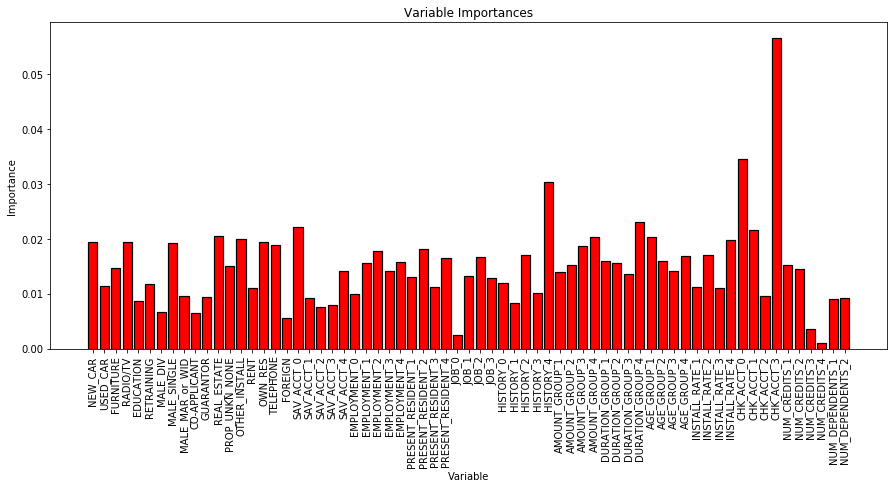

In [33]:
"""
Create a function to get a list of the top 5 importance features based on model results, and
chart importance features. Output is a list of important features with their
importance values. Importance value calculate with built-in model feature_importance_.
The chart is a bar chart.
"""
# Get numerical feature importances
rf_importances = list(rf_exp_par.feature_importances_)

def important_list (var_list, importances):
	# List of tuples with variable and importance
	feature_importances = [(feature, round(importance, 2)) for feature,
	importance in zip(var_list, importances)]
	# Sort the feature importances by most important first
	feature_importances = sorted(feature_importances,
	key = lambda x: x[1], reverse = True)
	# list of x locations for plotting
	x_values = list(range(len(importances)))
	return[ # Make a bar chart
	plt.bar(x_values, importances, orientation = 'vertical',
	color = 'r', edgecolor = 'k', linewidth = 1.2),
	# Tick labels for x axis
	plt.xticks(x_values, var_list, rotation='vertical'),
	# Axis labels and title
	plt.ylabel('Importance'), plt.xlabel('Variable'), plt.title('Variable Importances'),
	feature_importances[0:5]]

important_list(ind_var_list, rf_importances)

In [34]:
"""
Create and fit gradient boost model. No optimization and seed set at 42"""
gbrt=GradientBoostingClassifier(random_state=42)
gbrt.fit(train_features, train_labels)

#Use previous created function to produce binary predictions
gbrt_prdt=predct(gbrt)

In [35]:
#incorporate prediction results into the confusion matrix and generate metric reports
gbrt_confusion=confusion_matrix(test_labels, gbrt_prdt)
print("GB Confusion Matrix:\n\n {}".format(gbrt_confusion))

GB Confusion Matrix:

 [[186  23]
 [ 47  44]]


In [36]:
gbrt_class_report=classification_report(test_labels, gbrt_prdt)
print("\n\n GB Classification Report:\n\n {}".format(gbrt_class_report))



 GB Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.89      0.84       209
           1       0.66      0.48      0.56        91

    accuracy                           0.77       300
   macro avg       0.73      0.69      0.70       300
weighted avg       0.76      0.77      0.76       300



In [37]:
"""
Using previous function created, calculate accuracy, missclassifications, precision,
sensitivity based on the results of the confusion matrix. Output is a list with
values for each metric in the format ('Precision: [0.429]', 'Sensitivity: [0.696]'), etc...
"""
print(metric(gbrt_confusion))

['Accuracy: [0.767]', 'Missclassification: [0.233]', 'Precision: [0.484]', 'Sensitivity: [0.657]']


[<BarContainer object of 67 artists>,
 ([<matplotlib.axis.XTick at 0x26243042128>,
  <a list of 67 Text xticklabel objects>),
 Text(0, 0.5, 'Importance'),
 Text(0.5, 0, 'Variable'),
 Text(0.5, 1.0, 'Variable Importances'),
 [('CHK_ACCT_3', 0.13),
  ('HISTORY_4', 0.05),
  ('OTHER_INSTALL', 0.04),
  ('SAV_ACCT_0', 0.04),
  ('DURATION_GROUP_4', 0.04)]]

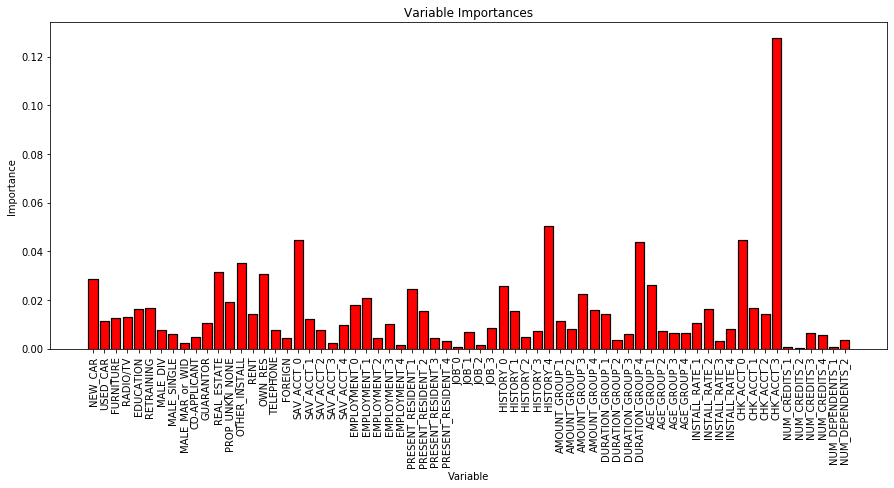

In [38]:
"""
Using previous function created, get a list of the top 5 importance
features based on model results, and chart importance features.
Output is a list of important features with their
importance values. Importance value calculate with built-in model feature_importance_.
The chart is a bar chart.
"""
g_importances = list(gbrt.feature_importances_)
important_list(ind_var_list, g_importances)

In [39]:
"""
Create subset training set for the logistic regression model.
"It is important to train the ensemble of trees on a different subset
of the training data than the linear regression model to avoid
overfitting, in particular if the total number of leaves is
similar to the number of training samples" (Pedregosa et al, 2011)
"""

X_train, X_train_lr, y_train, y_train_lr = train_test_split(
train_features, train_labels, test_size=0.3)

In [40]:
#create and fit the subset training data on logistic regression model
rt_lm = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
rt_lm.fit(X_train_lr, y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
#Use previous created function to produce binary predictions
lg_model=predct(rt_lm)

In [42]:
#incorporate prediction results into the confusion matrix and generate metric reports
tree_confusionlr=confusion_matrix(test_labels, lg_model)

In [43]:
print("Logistic Regression Confusion Matrix: {}".format(tree_confusionlr))
tree_class_reportlr=classification_report(test_labels, lg_model)

Logistic Regression Confusion Matrix: [[185  24]
 [ 62  29]]


In [44]:
print(tree_class_reportlr)

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       209
           1       0.55      0.32      0.40        91

    accuracy                           0.71       300
   macro avg       0.65      0.60      0.61       300
weighted avg       0.69      0.71      0.69       300



In [45]:
"""
Using previous function created, calculate accuracy, missclassifications, precision,
sensitivity based on the results of the confusion matrix. Output is a list with
values for each metric in the format ('Precision: [0.429]', 'Sensitivity: [0.696]'), etc...
"""

print(metric(tree_confusionlr))

['Accuracy: [0.713]', 'Missclassification: [0.287]', 'Precision: [0.319]', 'Sensitivity: [0.547]']


[<BarContainer object of 67 artists>,
 ([<matplotlib.axis.XTick at 0x26242f3ab00>,
  <a list of 67 Text xticklabel objects>),
 Text(0, 0.5, 'Importance'),
 Text(0.5, 0, 'Variable'),
 Text(0.5, 1.0, 'Variable Importances'),
 [('CHK_ACCT_3', 1.6),
  ('PRESENT_RESIDENT_1', 1.13),
  ('HISTORY_3', 1.0),
  ('NEW_CAR', 0.81),
  ('REAL_ESTATE', 0.78)]]

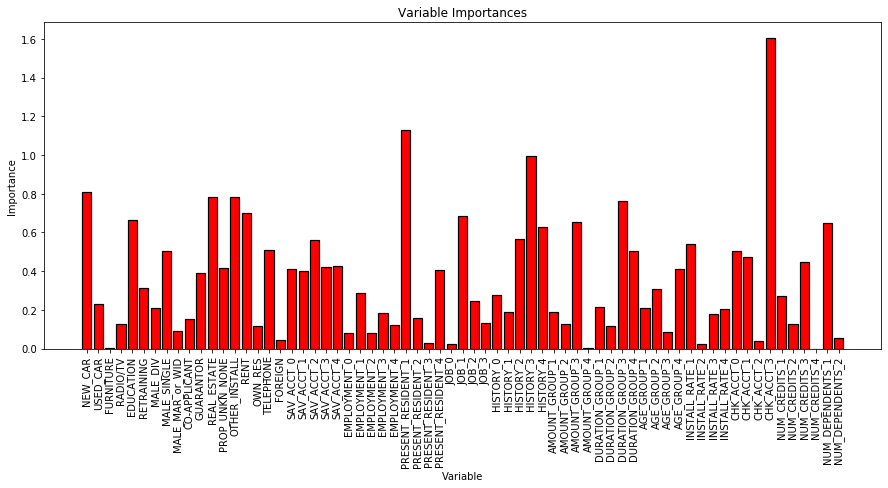

In [46]:
"""
Using previous function created, get a list of the top 5 importance
features based on model results, and chart importance features.
Output is a list of important features with their
importance values. Importance value calculate with built-in model feature_importance_.
The chart is a bar chart.
Transform and get numerical feature importances. Shape was modified to accomodate
unique features of the logistic regression model
"""

lg_coef=rt_lm.coef_.transpose()
lg_coef=lg_coef.reshape(lg_coef.shape[0], )
lg_importances = list(abs(lg_coef))
important_list(ind_var_list,lg_importances)

In [47]:
#create variables for prediction probabilities for each model
rf_predict=rf_exp_par.predict_proba(test_features)[:,1]
gb_predict=gbrt.predict_proba(test_features)[:,1]
y_pred_rt = rt_lm.predict_proba(test_features)[:,1]
#Create variables for precision/recall curve using predicted probability variables with test labels
fpr_rt_lm2, tpr_rt_lm2, _ = precision_recall_curve(test_labels, y_pred_rt)
fpr_rf2, tpr_rf2, _ = precision_recall_curve(test_labels, rf_predict)
fpr_grd2, tpr_grd2, _ = precision_recall_curve(test_labels, gb_predict)

In [48]:
"""
Calculate average precision/recall score for each model and plot
and plot the precision/recall curve for each model using
precision/recall score for labeling. Out put for scores are
("RF Average Precision/Recall Score 0.6331",
"LG Average Precision/Recall Score 0.5289"), etc...
"""
print("RF Average Precision/Recall Score {}".format(round(average_precision_score(test_labels, rf_predict),4
)))
print("LG Average Precision/Recall Score {}".format(round(average_precision_score(test_labels, y_pred_rt),4)))
print("GB Average Precision/Recall Score {}".format(round(average_precision_score(test_labels, gb_predict),4
)))

RF Average Precision/Recall Score 0.6269
LG Average Precision/Recall Score 0.5065
GB Average Precision/Recall Score 0.6137


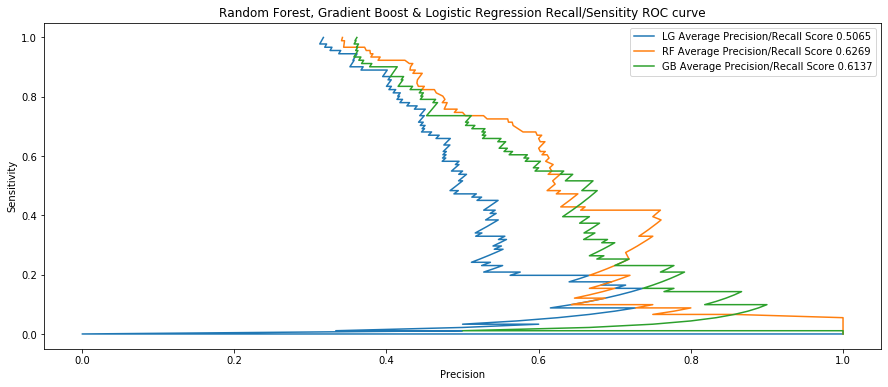

In [49]:
plt.figure(1)
#plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm2, tpr_rt_lm2, label="LG Average Precision/Recall Score {}".format(round(average_precision_score(test_labels, y_pred_rt),4)))
plt.plot(fpr_rf2, tpr_rf2, label="RF Average Precision/Recall Score {}".format(round(average_precision_score(test_labels, rf_predict),4)))
plt.plot(fpr_grd2, tpr_grd2, label="GB Average Precision/Recall Score {}".format(round(average_precision_score
(test_labels, gb_predict),4)))
plt.xlabel('Precision')
plt.ylabel('Sensitivity')
plt.title('Random Forest, Gradient Boost & Logistic Regression Recall/Sensitity ROC curve')
plt.legend(loc='best')
plt.show()

In [50]:
#create variables for ROC curve for each model
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(test_labels, y_pred_rt)
fpr_rf, tpr_rf, _ = roc_curve(test_labels, rf_predict)
fpr_grd, tpr_grd, _ = roc_curve(test_labels, gb_predict)

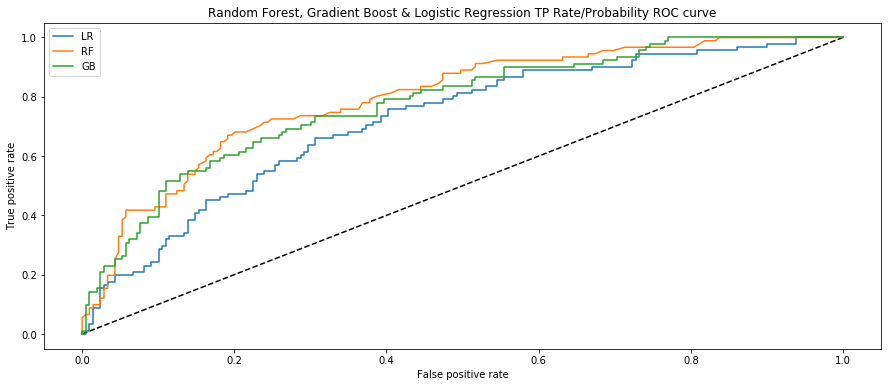

In [51]:
"""
Plot the precision/recall curve for each model
"""
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='LR')#.format(round(roc_auc_score(test_labels, y_pred_rt), 4)))
plt.plot(fpr_rf, tpr_rf, label='RF')#.format(round(roc_auc_score(test_labels2, rf_predict),4)))
plt.plot(fpr_grd, tpr_grd, label='GB')#.format(round(roc_auc_score(test_labels, gb_predict),4)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest, Gradient Boost & Logistic Regression TP Rate/Probability ROC curve')
plt.legend(loc='best')
plt.show()

In [52]:
"""
print ROC_AUC scores for each model. Output are ('LG ROC Score
RF ROC Score 0.7984'), etc...
"""
print("LG ROC Score {}".format(round(roc_auc_score(test_labels,y_pred_rt), 4)))
print("RF ROC Score {}".format(round(roc_auc_score(test_labels,rf_predict), 4)))
print("GB ROC Score {}".format(round(roc_auc_score(test_labels,gb_predict), 4)))


LG ROC Score 0.7192
RF ROC Score 0.796
GB ROC Score 0.778


In [53]:
"""
References:
Koehrsen, W. (2017). Random forest in python. Towards Data Science.
Retrieved from https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
Muller, A and Guido, S. (2017). Introduction to machine learning with python:
a guide for data scientists. Sabastopol, CA: O'Reilly Medial, Inc.
Pedregosa et al.(2011). Feature transformations with ensembles of trees.
Retrieved from https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html
"""

"\nReferences:\nKoehrsen, W. (2017). Random forest in python. Towards Data Science.\nRetrieved from https://towardsdatascience.com/random-forest-in-python-24d0893d51c0\nMuller, A and Guido, S. (2017). Introduction to machine learning with python:\na guide for data scientists. Sabastopol, CA: O'Reilly Medial, Inc.\nPedregosa et al.(2011). Feature transformations with ensembles of trees.\nRetrieved from https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html\n"